In [33]:
import cmocean.cm as cm
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd

import scipy.interpolate as interp
from scipy.stats import binned_statistic_2d

%matplotlib inline

In [2]:
mymesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask201702.nc')
depthf = interp.interp1d(mymesh.z, mymesh.gdept_1d)

In [3]:
years = 5
str_mo = ['jan', 'feb', 'mar', 'apr','may', 'jun', 'jul', 'aug', 'sep','oct', 'nov', 'dec']
int_mo = [1,2,3,4,5,6,7,8,9,10,11,12]
sections = [4,5,6] #haro, sanjuan, and rosario go into the JDF

In [4]:
# in you CS versions the comversion from m3/s to m/s happened via the binning+density step since you were dividing 
# by bin depth AND width, now you are only dividing by bin height SO must add an extra step where you divide by width
# for this stage i think fine to figure out the number of grid cells at each depth across all three CSs, 
# then assume that all of them have a width of 500 m

#in the format [jgridW, jgridE, figrid]
rosario = [286, 307, 266]
sanjuan = [264, 266, 280]
haro = [218, 242, 304]

# indmax = 33
# plotdepths = np.linspace(0,mymesh.gdept_1d[0,:][33],100)
plotdepths = mymesh.gdept_1d[0,:34]
#want to make a length 100 array with the total width for each depth

# find the number of cells (summed acrss the 3 CS) at each depth
figrid = [haro[2],sanjuan[2],rosario[2]]
lonW = [haro[0],sanjuan[0],rosario[0]]
lonE = [haro[1],sanjuan[1],rosario[1]]
igrid = [f-1 for f in figrid]
cells = np.zeros(33)

for i in range(len(igrid)):
    for d in range(33):
        fmask = mymesh.fmask[0, :, igrid[i],lonW[i]-2:lonE[i]+1]
        cells[d] += np.count_nonzero(fmask[d])

# find which depths you are plotting with fit into which SSC depth range
num = np.histogram(plotdepths,bins=mymesh.gdept_1d[0,:34])[0]
num[0] = 1

# based on this calc the total width at each plotting depth
width = np.array([])

for i in range(len(cells)):
    width = np.append(width,np.repeat(cells[i],num[i]))
width *= 500
width[0] = width[1]

#make a mesh of this indo so that you can easily divide 
_, W = np.meshgrid(np.arange(1,(years*12)+1,1), width)
plotdepths = np.append(0,plotdepths)

In [5]:
def get_data(mydata, section, starttime, endtime):
#     lons = mydata.final_lon[(mydata.final_section==section) & (mydata.init_t==time)]
    depths = depthf(mydata.final_z[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]-1.)[0]
    transports = mydata.final_transp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer1 = mydata.final_temp[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    tracer2 = mydata.final_salt[(mydata.final_section==section) & (mydata.init_t >= starttime) & (mydata.init_t <= endtime)]
    return depths, transports, tracer1, tracer2

In [6]:
def get_all_data_SoG(folder,forback):
    starttime = 1
    endtime = 720

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0

    #2016 and 2017
    year = [16,17]

    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+str(forback)+'ward_01jan'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=12

    #2019 and 2018 (both done month by month)
    year = [18,19]
    for num in year:
        k += 12
        for i in range(len(str_mo)):
            file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/'+str(forback)+'ward_01'+str_mo[i]+str(num)+'/ariane_positions_quantitative.nc'
            mydata = xr.open_dataset(file)
            time = mydata.init_t[-1]

            for section in sections:
                depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
                tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
                tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
                transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
                month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/'+str(forback)+'ward_01jan20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [7]:
back_mo = ['31jan','03mar','31mar','01may','31may','01jul','31jul','31aug','01oct','31oct','01dec','31dec']

def BACK_get_all_data_SoG(folder):
    starttime = 721
    endtime = 1440

    depths = np.array([])
    transports = np.array([])
    tracer1 = np.array([])
    tracer2 = np.array([])
    month = np.array([])
    k = 0
    
    #2016 (month by month)
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'16/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))

    #2017 and 2018
    k=12
    year = [17,18]
    for num in year:
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec'+str(num)+'/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        for i in range(12):
            for section in sections:
                tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

                depths = np.append(depths, tempD)
                transports = np.append(transports, tempT/720)
                tracer1 = np.append(tracer1, tempt1)
                tracer2 = np.append(tracer2, tempt2)
                month = np.append(month, np.full(len(tempD),i+k+1))
        k=24

    #2019 and (month by month)
    k=36
    for i in range(len(str_mo)):
        file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/201905_'+str(folder)+'/backward_'+back_mo[i]+'19/ariane_positions_quantitative.nc'
        mydata = xr.open_dataset(file)
        time = mydata.init_t[-1]

        for section in sections:
            depths = np.append(depths, depthf(mydata.final_z[(mydata.final_section==section)]-1.)[0])
            tracer1 = np.append(tracer1, mydata.final_temp[(mydata.final_section==section)])
            tracer2 = np.append(tracer2, mydata.final_salt[(mydata.final_section==section)])
            transports = np.append(transports, mydata.final_transp[(mydata.final_section==section)]/time)
            month = np.append(month, np.full(len(mydata.final_salt[(mydata.final_section==section)]),i+k+1))
    
    #2020
    k=48
    file = '/ocean/rbeutel/MOAD/analysis-becca/Ariane/1yr_runs/201905_'+str(folder)+'/backward_31dec20/ariane_positions_quantitative.nc'
    mydata = xr.open_dataset(file)
    for i in range(12):
        for section in sections:
            tempD, tempT, tempt1, tempt2 = get_data(mydata, section, starttime+(i*720), endtime+(i*720))

            depths = np.append(depths, tempD)
            transports = np.append(transports, tempT/720)
            tracer1 = np.append(tracer1, tempt1)
            tracer2 = np.append(tracer2, tempt2)
            month = np.append(month, np.full(len(tempD),i+k+1))
    
    return depths, transports, tracer1, tracer2, month

In [8]:
#ambient concentrations from "AmbientTracerConc.ipynb"
amC = 2104.4632427854353 #mmol/m3
amSi = 37.46235074714988 #mmol/m3
amSa = 31.417757428541577 #g/kg
amN = 23.037677314276408 #mmol/m3

Text(0, 0.5, 'Depth (m)')

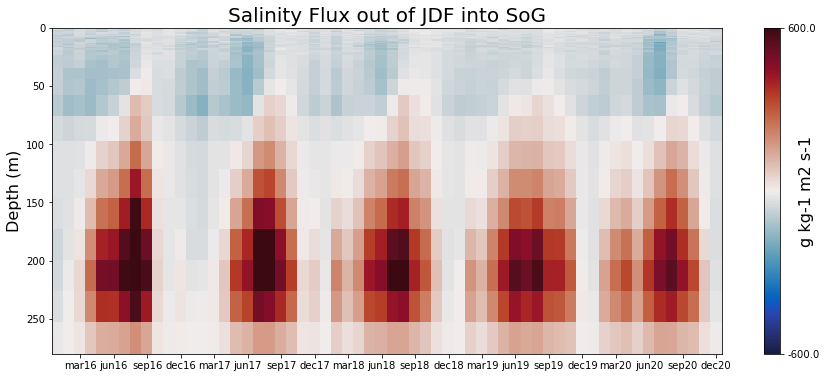

In [13]:
folder = 'Car_Sal'
forback = 'for'
# Car_Sal_depths, Car_Sal_transports, carbon, salinity, Car_Sal_month = get_all_data_SoG(folder,forback)
month_edge = np.arange(0.5,61.5,1)

vmax = (600/sum(Car_Sal_transports))

H1, xedges1, yedges1 = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= Car_Sal_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Car_Sal_month, Car_Sal_depths, salinity, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T - amSa)
H_final= H1.T * (H.statistic.T - amSa)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(Car_Sal_transports)),1), np.round((vmax * sum(Car_Sal_transports)),1)])
cb1.set_label('g kg-1 m2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux out of JDF into SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

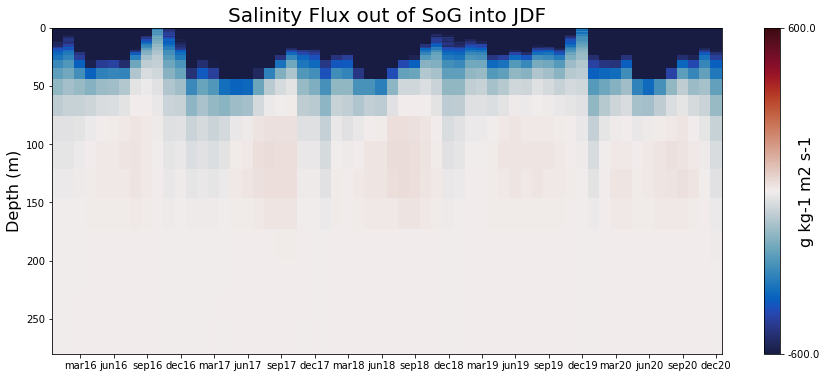

In [19]:
folder = 'Car_Sal'
BACK_Car_Sal_depths, BACK_Car_Sal_transports, Bcarbon, Bsalinity, BACK_Car_Sal_month = BACK_get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

vmax = (600/sum(BACK_Car_Sal_transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= BACK_Car_Sal_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, Bsalinity, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T - amSa)
H_final= H1.T * (H.statistic.T - amSa)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(BACK_Car_Sal_transports)),1), np.round((vmax * sum(BACK_Car_Sal_transports)),1)])
cb1.set_label('g kg-1 m2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Salinity Flux out of SoG into JDF', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

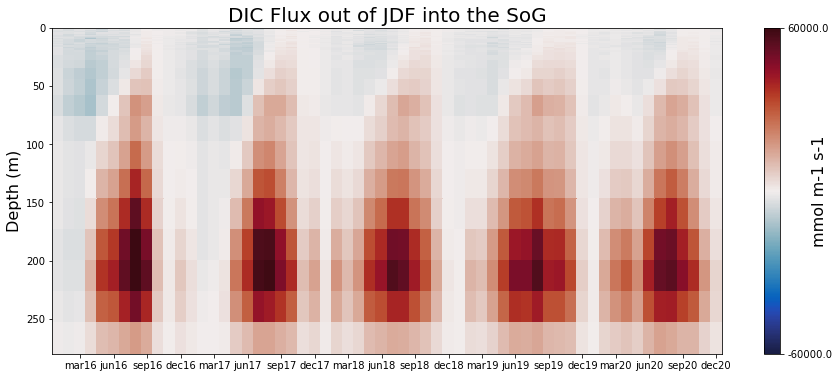

In [18]:
vmax = (60000/sum(Car_Sal_transports))

H1, xedges1, yedges1 = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= Car_Sal_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Car_Sal_month, Car_Sal_depths, carbon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Car_Sal_month, Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T-amC)
H_final= H1.T * (H.statistic.T-amC)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(Car_Sal_transports)),1), np.round((vmax * sum(Car_Sal_transports)),1)])
cb1.set_label('mmol m-1 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('DIC Flux out of JDF into the SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

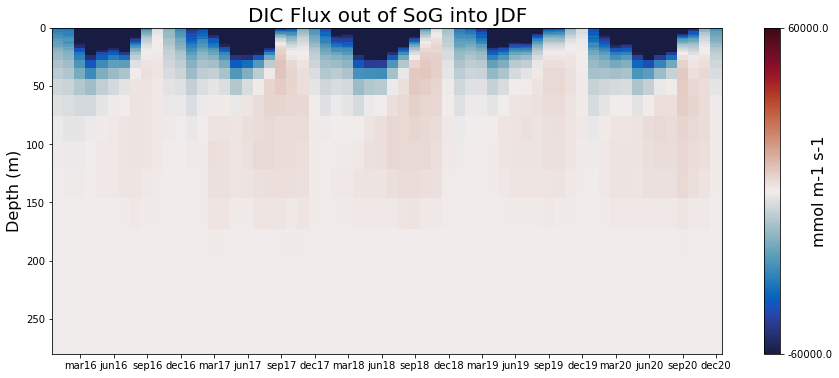

In [20]:
vmax = (60000/sum(BACK_Car_Sal_transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins=[month_edge,plotdepths] ,weights= BACK_Car_Sal_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, Bcarbon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Car_Sal_month, BACK_Car_Sal_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T-amC)
H_final= H1.T * (H.statistic.T-amC)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(BACK_Car_Sal_transports)),1), np.round((vmax * sum(BACK_Car_Sal_transports)),1)])
cb1.set_label('mmol m-1 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('DIC Flux out of SoG into JDF', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

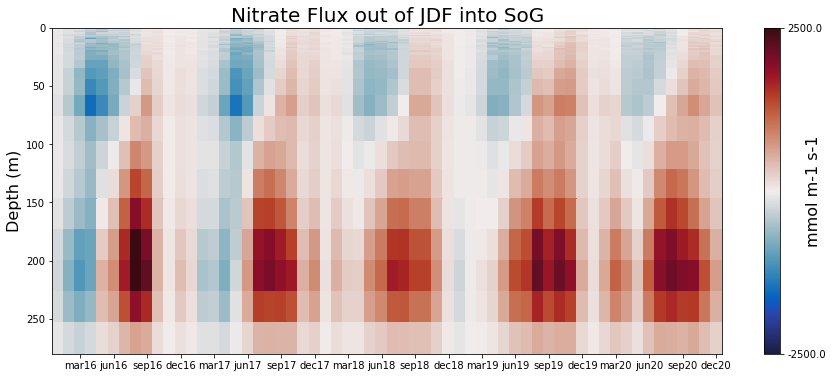

In [23]:
folder = 'Nit_Sil'
forback = 'for'
# Nit_Sil_depths, Nit_Sil_transports, nitrate, silicon, Nit_Sil_month = get_all_data_SoG(folder,forback)
month_edge = np.arange(0.5,61.5,1)

vmax = (2500/sum(Nit_Sil_transports))

H1, xedges1, yedges1 = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= Nit_Sil_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Nit_Sil_month, Nit_Sil_depths, nitrate, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T-amN)
H_final= H1.T * (H.statistic.T-amN)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1* np.round((vmax * sum(Nit_Sil_transports)),1), np.round((vmax * sum(Nit_Sil_transports)),1)])
cb1.set_label('mmol m-1 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Nitrate Flux out of JDF into SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

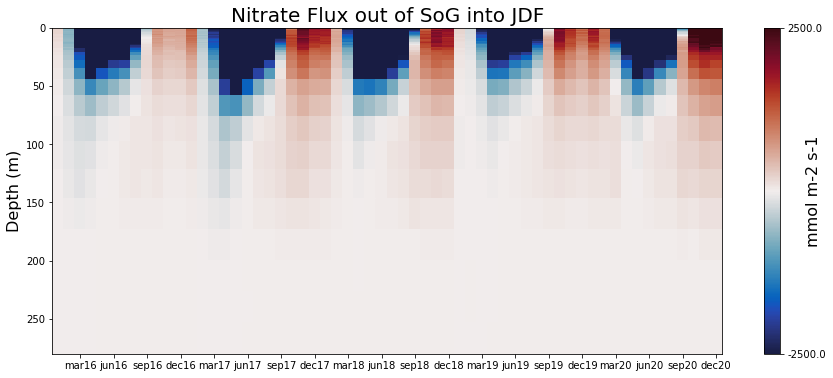

In [30]:
folder = 'Nit_Sil'
forback = 'for'
BACK_Nit_Sil_depths, BACK_Nit_Sil_transports, Bnitrate, Bsilicon, BACK_Nit_Sil_month = BACK_get_all_data_SoG(folder)
month_edge = np.arange(0.5,61.5,1)

vmax = (2500/sum(BACK_Nit_Sil_transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= BACK_Nit_Sil_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(BACK_Nit_Sil_month,BACK_Nit_Sil_depths, Bnitrate, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T-amN)
H_final= H1.T * (H.statistic.T-amN)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1* np.round((vmax * sum(BACK_Nit_Sil_transports)),1), np.round((vmax * sum(BACK_Nit_Sil_transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Nitrate Flux out of SoG into JDF', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

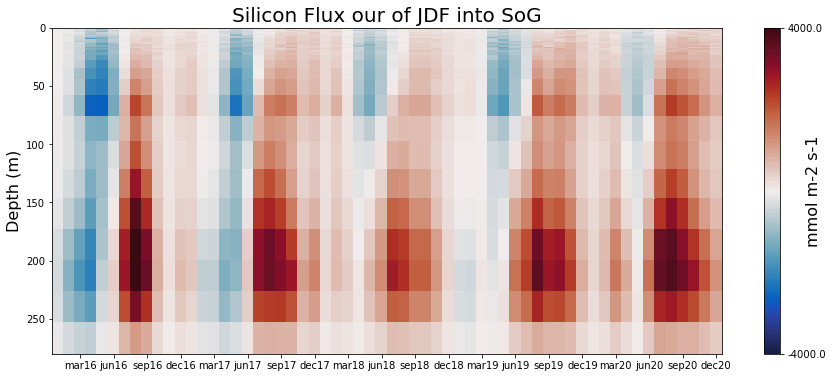

In [27]:
vmax = (4000/sum(Nit_Sil_transports))

H1, xedges1, yedges1 = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins=[month_edge,plotdepths] ,weights= Nit_Sil_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Nit_Sil_month, Nit_Sil_depths, silicon, statistic=np.mean, bins=[month_edge,plotdepths])
_, xedges, yedges = np.histogram2d(Nit_Sil_month, Nit_Sil_depths, bins = [month_edge,plotdepths])
   
# H_final= (H1.T/W) * (H.statistic.T-amSi)
H_final= H1.T * (H.statistic.T-amSi)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(Nit_Sil_transports)),1), np.round((vmax * sum(Nit_Sil_transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Silicon Flux our of JDF into SoG', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

Text(0, 0.5, 'Depth (m)')

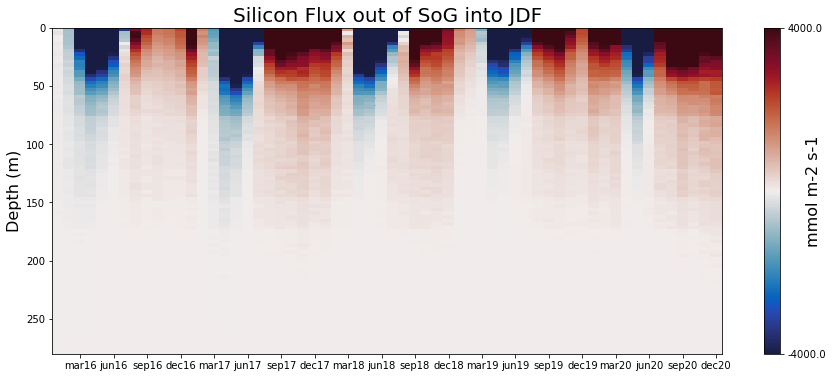

In [31]:
vmax = (4000/sum(BACK_Nit_Sil_transports))

H1, xedges1, yedges1 = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins=[month_edge,100] ,weights= BACK_Nit_Sil_transports, density= True)# vmax=vmax)

H = binned_statistic_2d(Nit_Sil_month, Nit_Sil_depths, silicon, statistic=np.mean, bins=[month_edge,100])
_, xedges, yedges = np.histogram2d(BACK_Nit_Sil_month, BACK_Nit_Sil_depths, bins = [month_edge,100])
   
# H_final= (H1.T/W) * (H.statistic.T-amSi)
H_final= H1.T * (H.statistic.T-amSi)
np.nan_to_num(H_final, nan=0, copy=False)

fig, ax = plt.subplots(1, 1, figsize = (15, 6))
    
X, Y = np.meshgrid(xedges, yedges)
cmap = cm.balance
im = ax.pcolormesh(X, Y, H_final, vmax = vmax, vmin = -vmax, cmap=cmap)
cb1 = fig.colorbar(im, ax=ax)
cb1.set_ticks([-vmax, vmax])
cb1.set_ticklabels([-1*np.round((vmax * sum(BACK_Nit_Sil_transports)),1), np.round((vmax * sum(BACK_Nit_Sil_transports)),1)])
cb1.set_label('mmol m-2 s-1', labelpad=-20,fontsize = 16)
    
ax.invert_yaxis()
ax.set_ylim((280, 0))
ax.set_xlim((0.5,60.5))
ax.set_title('Silicon Flux out of SoG into JDF', fontsize = 20)
ax.set_xticks(np.arange(3,61,3))
ax.set_xticklabels(['mar16','jun16','sep16','dec16','mar17','jun17','sep17','dec17','mar18','jun18','sep18','dec18','mar19','jun19','sep19','dec19','mar20','jun20','sep20','dec20'])
ax.set_ylabel('Depth (m)',fontsize = 16)

### Net flux

In [34]:
#forward Salinity and Carbon
d = {'carbon': carbon, 'salinity': salinity, 'transport': Car_Sal_transports, 'month':Car_Sal_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_for = np.array([])
carb_sum_for = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    carb_sum_for = np.append(carb_sum_for,sum((tracerC-amC)*transports)/1000*(44.01/1000))
    saln_sum_for = np.append(saln_sum_for,sum((tracerSa-amSa)*transports))  

In [35]:
#backward Salinity and Carbon
d = {'carbon': Bcarbon, 'salinity': Bsalinity, 'transport': BACK_Car_Sal_transports, 'month':BACK_Car_Sal_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
saln_sum_back = np.array([])
carb_sum_back = np.array([])

for mo in months:
    tracerC = df.query("month == " +str(mo))['carbon']
    tracerSa = df.query("month == " +str(mo))['salinity']
    transports = df.query("month == " +str(mo))['transport']
    carb_sum_back = np.append(carb_sum_back,sum((tracerC-amC)*transports)/1000*(44.01/1000))
    saln_sum_back = np.append(saln_sum_back,sum((tracerSa-amSa)*transports)) 

In [36]:
#forward Nitrate and Silicon
d = {'nitrate': nitrate, 'silicon': silicon, 'transport': Nit_Sil_transports, 'month':Nit_Sil_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_for = np.array([])
sili_sum_for = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_for = np.append(nitr_sum_for,sum((tracerN-amN)*transports)/1000*(62.0049/1000))
    sili_sum_for = np.append(sili_sum_for,sum((tracerSi-amSi)*transports)/1000*(60.08/1000))

In [37]:
#backward Nitrate and Silicon
d = {'nitrate': Bnitrate, 'silicon': Bsilicon, 'transport': BACK_Nit_Sil_transports, 'month':BACK_Nit_Sil_month}
df = pd.DataFrame(data=d)

months = np.arange(1,61,1)
nitr_sum_back = np.array([])
sili_sum_back = np.array([])

for mo in months:
    tracerSi = df.query("month == " +str(mo))['silicon']
    tracerN = df.query("month == " +str(mo))['nitrate']
    transports = df.query("month == " +str(mo))['transport']
    nitr_sum_back = np.append(nitr_sum_back,sum((tracerN-amN)*transports)/1000*(62.0049/1000))
    sili_sum_back = np.append(sili_sum_back,sum((tracerSi-amSi)*transports)/1000*(60.08/1000))

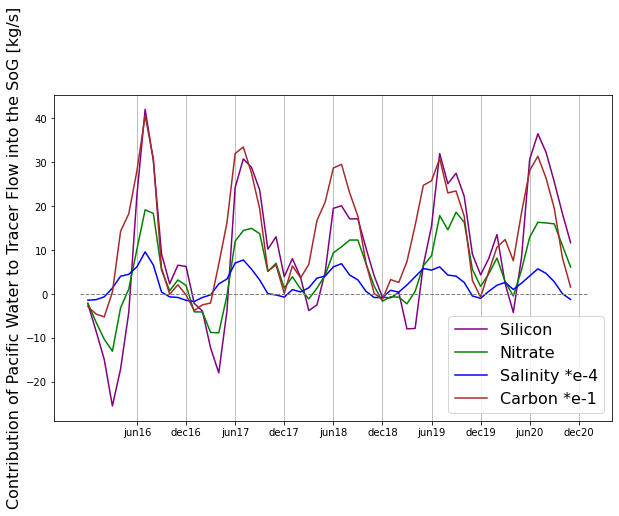

In [55]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_for,label='Silicon', c='purple')
ax.plot(nitr_sum_for,label='Nitrate', c='green')
ax.plot(saln_sum_for/10000,label='Salinity *e-4', c='b')
ax.plot(carb_sum_for/10,label='Carbon *e-1', c='brown')

ax.plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax.legend(fontsize = 16)
# ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax.set_ylabel('Contribution of Pacific Water to Tracer Flow into the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')

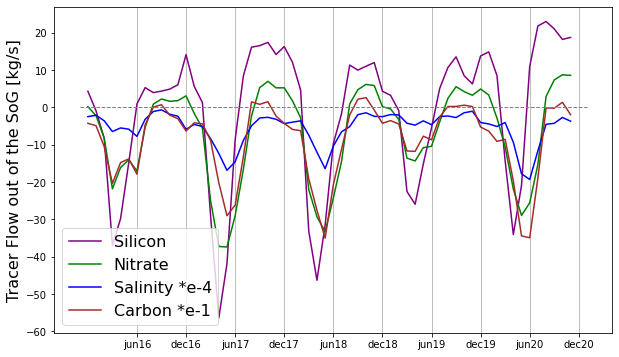

In [53]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_back,label='Silicon', c='purple')
ax.plot(nitr_sum_back,label='Nitrate', c='green')
ax.plot(saln_sum_back/10000,label='Salinity *e-4', c='b')
ax.plot(carb_sum_back/10,label='Carbon *e-1', c='brown')

ax.plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax.legend(fontsize = 16)
# ax.set_ylim([-200,200])
# ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
# ax.set_xlim(-0.2,len(str_mo)-0.8)
ax.set_ylabel('Tracer Flow out of the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')

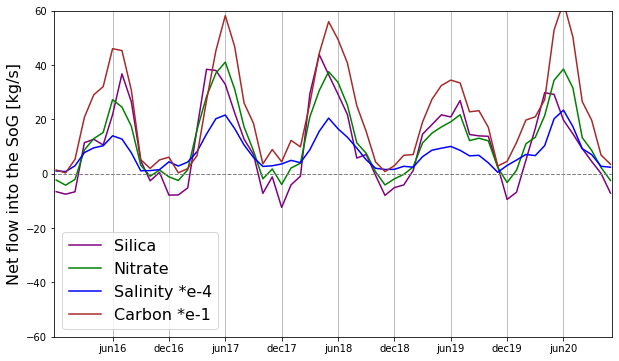

In [52]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))

ax.plot(sili_sum_for-sili_sum_back,label='Silica', c='purple')
ax.plot(nitr_sum_for-nitr_sum_back,label='Nitrate', c='green')
ax.plot((saln_sum_for-saln_sum_back)/10000,label='Salinity *e-4', c='b')
ax.plot((carb_sum_for-carb_sum_back)/10,label='Carbon *e-1', c='brown')

ax.plot(np.arange(-1,60+2), np.full(len(np.arange(-1,60+2)),0), c='grey',ls='--',lw=1)

ax.legend(fontsize = 16)
ax.set_ylim([-60,60])
# ax.set_yscale('log')
ax.set_xticks(np.arange(6,61,6))
ax.set_xticklabels(['jun16','dec16','jun17','dec17','jun18','dec18','jun19','dec19','jun20','dec20'])
ax.set_xlim(-0.2,60-0.8)
ax.set_ylabel('Net flow into the SoG [kg/s]', fontsize = 16)
ax.grid(axis='x', which='both')